In [1]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support as prfs_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import numpy as np
import shap
import matplotlib.pyplot as plt

In [2]:
####### get feature table for ml

featureTable_c4_raw = pd.read_csv("../../feature/FeatureTables/featureTable_separatedByTypeNonSelected_halfLifeFcClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_5pUTR_complete.csv", header = 0)
featureTable_c4 = featureTable_c4_raw.iloc[:, 2:]
featureTable_c4 = featureTable_c4.dropna()
X_c4 = featureTable_c4.iloc[:, :-1]
y_c4 = featureTable_c4.HalfLife_FCcls_hypoxiaToLogPhase
y_labels = sorted(y_c4.unique())

############## feature table stats 
print(X_c4.shape)
print(y_c4.shape)
print(y_labels)
y_c4.value_counts()
# X_c4.head()


(1026, 58)
(1026,)
['Large', 'Med-large', 'Med-small', 'Small']


Small        284
Med-large    267
Med-small    256
Large        219
Name: HalfLife_FCcls_hypoxiaToLogPhase, dtype: int64

In [3]:
####### hyperparameters tuning for random forest classifier

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [20, 30, 50],
    'min_samples_split': [5, 10, 20]
}


In [4]:
####### random search for hyperparameters

def hyp_cv(X, y, model, hyperparams, cvf):
    rnd_search = RandomizedSearchCV(model, hyperparams, cv = cvf, scoring = 'f1_macro', verbose = 0, n_iter = 20)
    rnd_search.fit(X, y)
    model = rnd_search.best_estimator_
    return model


In [5]:
####### stratified k fold split

def skf(X, y, n_fold):
    train_skf_idex = []
    test_skf_idex = []
    skf = StratifiedKFold(n_splits = n_fold, shuffle = True)
    for train_index, test_index in skf.split(X, y):
        train_skf_idex.append(train_index)
        test_skf_idex.append(test_index)
    return train_skf_idex, test_skf_idex


In [6]:
####### get feature importance ranking

def feature_importance(X, model_importance):    
    feature_importances = pd.DataFrame(model_importance, index = X.columns, 
                                       columns = ['importance']).sort_values('importance', ascending = False)
    dict_importance = dict(zip(feature_importances.index, feature_importances.importance))    
    return dict_importance


In [7]:
####### k fold nested cross-validation

def training(X, y, fold, hyperparams):
    
    train_idex, test_idex = skf(X, y, fold)
    ml = RandomForestClassifier(class_weight = "balanced", n_jobs = 8, n_estimators = 1000)
    
    fscore_ml = []
    precision_ml = []
    recall_ml = []
    
    fscore_cl = []
    precision_cl = []
    recall_cl = []
    support_cl = []
    
    fscore_dummy = {}
    precision_dummy = {}
    recall_dummy = {}
    
    for strat in ['stratified', 'most_frequent', 'uniform']:
        fscore_dummy[strat] = []
        precision_dummy[strat] = []
        recall_dummy[strat] = []
        
    fscore = {}
    fscore_avg = {}
    precision = {}
    precision_avg = {}
    recall = {}
    recall_avg = {}
    support_avg = {}
    
    feature_cv = {}
    feature_avg = {}
    for feature in X.columns:
        feature_cv[feature] = []
        
    list_shap_values = list()
    list_test_sets = list()
    
    for i in range(fold):
        X_train = X.iloc[train_idex[i]]
        y_train = y.iloc[train_idex[i]]
        X_test = X.iloc[test_idex[i]]
        y_test = y.iloc[test_idex[i]]

        ml_best_model = hyp_cv(X_train, y_train, ml, hyperparams, fold)
        ml_best_model.fit(X_train, y_train)
        y_pred_ml = ml_best_model.predict(X_test)
        
        explainer = shap.TreeExplainer(ml_best_model)
        shap_values = explainer.shap_values(X_test)
        list_shap_values.append(shap_values)
        list_test_sets.append(test_idex[i])
        
        feature_i = feature_importance(X, ml_best_model.feature_importances_)
        
        fscore_ml_i = f1_score(y_test, y_pred_ml, average = "macro")
        
        fscore_ml.append(fscore_ml_i)
        
        precision_ml_i = precision_score(y_test, y_pred_ml, average = "macro", zero_division = 0)
        precision_ml.append(precision_ml_i)
        
        recall_ml_i = recall_score(y_test, y_pred_ml, average = "macro", zero_division = 0)
        recall_ml.append(recall_ml_i)
        
        y_labels = sorted(y.unique())
        precision_cl_i, recall_cl_i, fscore_cl_i, support_cl_i = prfs_score(y_test, y_pred_ml, labels = [y_labels[0], y_labels[1], y_labels[2], y_labels[3]], zero_division = 0)
        precision_cl.append(precision_cl_i)
        recall_cl.append(recall_cl_i)
        fscore_cl.append(fscore_cl_i)
        support_cl.append(support_cl_i)
               
        for feature in feature_cv.keys():
            feature_cv[feature].append(feature_i[feature])
                    
        for strat in ['stratified', 'most_frequent', 'uniform']:
            dummy_strat = DummyClassifier(strategy = strat)
            dummy_strat.fit(X_train, y_train)
            y_pred_strat = dummy_strat.predict(X_test)
            fscore_strat = f1_score(y_test, y_pred_strat, average = "macro")
            fscore_dummy[strat].append(fscore_strat)
            precision_strat = precision_score(y_test, y_pred_strat, average = "macro", zero_division = 0)
            precision_dummy[strat].append(precision_strat)
            recall_strat = recall_score(y_test, y_pred_strat, average = "macro", zero_division = 0)
            recall_dummy[strat].append(recall_strat)
    
    test_sets = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])
    for i in range(1, len(list_test_sets)):
        test_sets = np.concatenate((test_sets, list_test_sets[i]), axis = 0)
        shap_values = np.concatenate((shap_values, np.array(list_shap_values[i])), axis = 1)
        
    fscore['ml_5fdcv'] = fscore_ml
    precision['ml_5fdcv'] = precision_ml
    recall['ml_5fdcv'] = recall_ml
    
    fscore_cl_avg = np.mean(fscore_cl, axis = 0)
    precision_cl_avg = np.mean(precision_cl, axis = 0)
    recall_cl_avg = np.mean(recall_cl, axis = 0)
    support_cl_avg = np.mean(support_cl, axis = 0)
    
    for k_model, v_score in fscore_dummy.items():
        fscore[k_model] = v_score

    for k_model, v_score_cv in fscore.items():
        fscore_avg[k_model] = np.mean(v_score_cv)
    
    for k_model, v_score in precision_dummy.items():
        precision[k_model] = v_score
        
    for k_model, v_score_cv in precision.items():
        precision_avg[k_model] = np.mean(v_score_cv)
    
    for k_model, v_score in recall_dummy.items():
        recall[k_model] = v_score

    for k_model, v_score_cv in recall.items():
        recall_avg[k_model] = np.mean(v_score_cv)
    
    for feature in feature_cv.keys():
        feature_avg[feature] = np.mean(feature_cv[feature])

    return fscore, fscore_avg, feature_avg, precision_avg, recall_avg, fscore_cl_avg, precision_cl_avg, recall_cl_avg, support_cl_avg, shap_values, test_sets


In [8]:
####### recombine metrics of repeated runs for each class

def perclass_metrics(i, metric):
    metric_class_i = [item[i] for item in metric] 
    return metric_class_i


In [9]:
####### repeated runs

def repeat_training(X, y, fold, hyperparams, n_times):
    
    y_labels = len(y.unique())
    
    fscore_allFold_repeat = {}
    fscore_avg_repeat = {}
    precision_repeat = {}
    recall_repeat = {}
    
    fscore_cl_repeat = []
    precision_cl_repeat = []
    recall_cl_repeat = []
    support_cl_repeat = []
    
    # repeats for each class
    fscore_cl_repeat_perclass = []
    precision_cl_repeat_perclass = []
    recall_cl_repeat_perclass = []
    support_cl_repeat_perclass = []
    
    for model in ['ml_5fdcv', 'stratified', 'most_frequent', 'uniform']:
        fscore_allFold_repeat[model] = []
        fscore_avg_repeat[model] = []
        precision_repeat[model] = []
        recall_repeat[model] = []
    
    feature_repeat = {}
    for feature in X.columns:
        feature_repeat[feature] = []

    tests_repeat = []
    shap_values_repeat = []

    for i in range(1, n_times + 1):
        print('Training and evaluation repeated: ' + str(i))
        fscore_allFold_i, fscore_avg_i, feature_i, precision_i, recall_i, fscore_cl_i, precision_cl_i, recall_cl_i, support_cl_i, shap_values_i, test_sets_i = training(X, y, fold, hyperparams)
        
        for k_model, v_score in fscore_allFold_i.items():
            for score_fold_i in v_score:
                fscore_allFold_repeat[k_model].append(score_fold_i)
        for k_model, v_score in fscore_avg_i.items():
            fscore_avg_repeat[k_model].append(v_score)
        for k_model, v_score in precision_i.items():
            precision_repeat[k_model].append(v_score)
        for k_model, v_score in recall_i.items():
            recall_repeat[k_model].append(v_score)
        for k_feature, v_imp in feature_i.items():
            feature_repeat[k_feature].append(v_imp)
            
        tests_repeat.append(test_sets_i)
        shap_values_repeat.append(shap_values_i)
        
        fscore_cl_repeat.append(fscore_cl_i)
        precision_cl_repeat.append(precision_cl_i)
        recall_cl_repeat.append(recall_cl_i)
        support_cl_repeat.append(support_cl_i)

    test_sets_all = tests_repeat[0]
    shap_values_all = np.array(shap_values_repeat[0])
    for i in range(1, len(tests_repeat)):
        test_sets_all = np.concatenate((test_sets_all, tests_repeat[i]), axis = 0)
        shap_values_all = np.concatenate((shap_values_all, np.array(shap_values_repeat[i])), axis = 1)
   
    file_fscore_allFold = open('../ml_metrics_halfLifeFcClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_fscore_allFold.txt', 'w')
    for k_model, v_score in fscore_allFold_repeat.items():
        print(k_model, ' '.join(str(x) for x in v_score), file = file_fscore_allFold)
    
    file_fscore_avg = open('../ml_metrics_halfLifeFcClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_fscore_avg.txt', 'w')
    for k_model, v_score in fscore_avg_repeat.items():
        print(k_model, np.mean(v_score), np.amin(v_score), np.max(v_score), np.around(np.std(v_score), 4), 
              ' '.join(str(x) for x in v_score), file = file_fscore_avg)

    file_precision = open('../ml_metrics_halfLifeFcClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_precision.txt', 'w')
    for k_model, v_score in precision_repeat.items():
        print(k_model, np.mean(v_score), np.amin(v_score), np.max(v_score), np.around(np.std(v_score), 4), 
              ' '.join(str(x) for x in v_score), file = file_precision)

    file_recall = open('../ml_metrics_halfLifeFcClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_recall.txt', 'w')
    for k_model, v_score in recall_repeat.items():
        print(k_model, np.mean(v_score), np.amin(v_score), np.max(v_score), np.around(np.std(v_score), 4), 
              ' '.join(str(x) for x in v_score), file = file_recall)

    file_feature = open('../ml_features_halfLifeFcClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_feature.txt', 'w')
    for k_feature, v_imp in feature_repeat.items():
        print(k_feature, np.mean(v_imp), np.around(np.std(v_imp), 4), file = file_feature)

    file_fscore_cl = open('../ml_metrics_halfLifeFcClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_fscore_cl.txt', 'w')
    fscore_cl_avg = np.mean(fscore_cl_repeat, axis = 0)
    for i in range(y_labels):
        fscore_i = perclass_metrics(i, fscore_cl_repeat)
        print(str(fscore_cl_avg[i]) + '\t' + '\t'.join(str(x) for x in fscore_i), file = file_fscore_cl)

    file_precision_cl = open('../ml_metrics_halfLifeFcClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_precision_cl.txt', 'w')
    precision_cl_avg = np.mean(precision_cl_repeat, axis = 0)
    for i in range(y_labels):
        precision_i = perclass_metrics(i, precision_cl_repeat)
        print(str(precision_cl_avg[i]) + '\t' + '\t'.join(str(x) for x in precision_i), file = file_precision_cl)

    file_recall_cl = open('../ml_metrics_halfLifeFcClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_recall_cl.txt', 'w')
    recall_cl_avg = np.mean(recall_cl_repeat, axis = 0)
    for i in range(y_labels):
        recall_i = perclass_metrics(i, recall_cl_repeat)
        print(str(recall_cl_avg[i]) + '\t' + '\t'.join(str(x) for x in recall_i), file = file_recall_cl)

    file_support_cl = open('../ml_metrics_halfLifeFcClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_support_cl.txt', 'w')
    support_cl_avg = np.mean(support_cl_repeat, axis = 0)
    for i in range(y_labels):
        support_i = perclass_metrics(i, support_cl_repeat)
        print(str(support_cl_avg[i]) + '\t' + '\t'.join(str(x) for x in support_i), file = file_support_cl)
        
    return shap_values_all, test_sets_all


In [10]:
####### running 5 fold nested cross-validation, repeated 10 times

shap_values, test_sets = repeat_training(X_c4, y_c4, 5, param_grid, 10)


Training and evaluation repeated: 1
Training and evaluation repeated: 2
Training and evaluation repeated: 3
Training and evaluation repeated: 4
Training and evaluation repeated: 5
Training and evaluation repeated: 6
Training and evaluation repeated: 7
Training and evaluation repeated: 8
Training and evaluation repeated: 9
Training and evaluation repeated: 10


In [11]:
####### get SHAP values and SHAP plots for each class

X_test = pd.DataFrame(X_c4.iloc[test_sets])

feature_names = list(X_c4.columns)
SHAP_names = [feature + '_SHAP' for feature in feature_names]

rf_result_clsLarge_p1 = pd.DataFrame(shap_values[0], columns = SHAP_names)
rf_result_clsLarge = X_test.reset_index(drop = True).join(rf_result_clsLarge_p1)
rf_result_clsLarge.to_csv('../SHAP_values/SHAPvals_HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_Large.csv', index = False)

rf_result_clsMedLarge_p1 = pd.DataFrame(shap_values[1], columns = SHAP_names)
rf_result_clsMedLarge = X_test.reset_index(drop = True).join(rf_result_clsMedLarge_p1)
rf_result_clsMedLarge.to_csv('../SHAP_values/SHAPvals_HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_MedLarge.csv', index = False)

rf_result_clsMedSmall_p1 = pd.DataFrame(shap_values[2], columns = SHAP_names)
rf_result_clsMedSmall = X_test.reset_index(drop = True).join(rf_result_clsMedSmall_p1)
rf_result_clsMedSmall.to_csv('../SHAP_values/SHAPvals_HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_MedSmall.csv', index = False)

rf_result_clsSmall_p1 = pd.DataFrame(shap_values[3], columns = SHAP_names)
rf_result_clsSmall = X_test.reset_index(drop = True).join(rf_result_clsSmall_p1)
rf_result_clsSmall.to_csv('../SHAP_values/SHAPvals_HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_Small.csv', index = False)


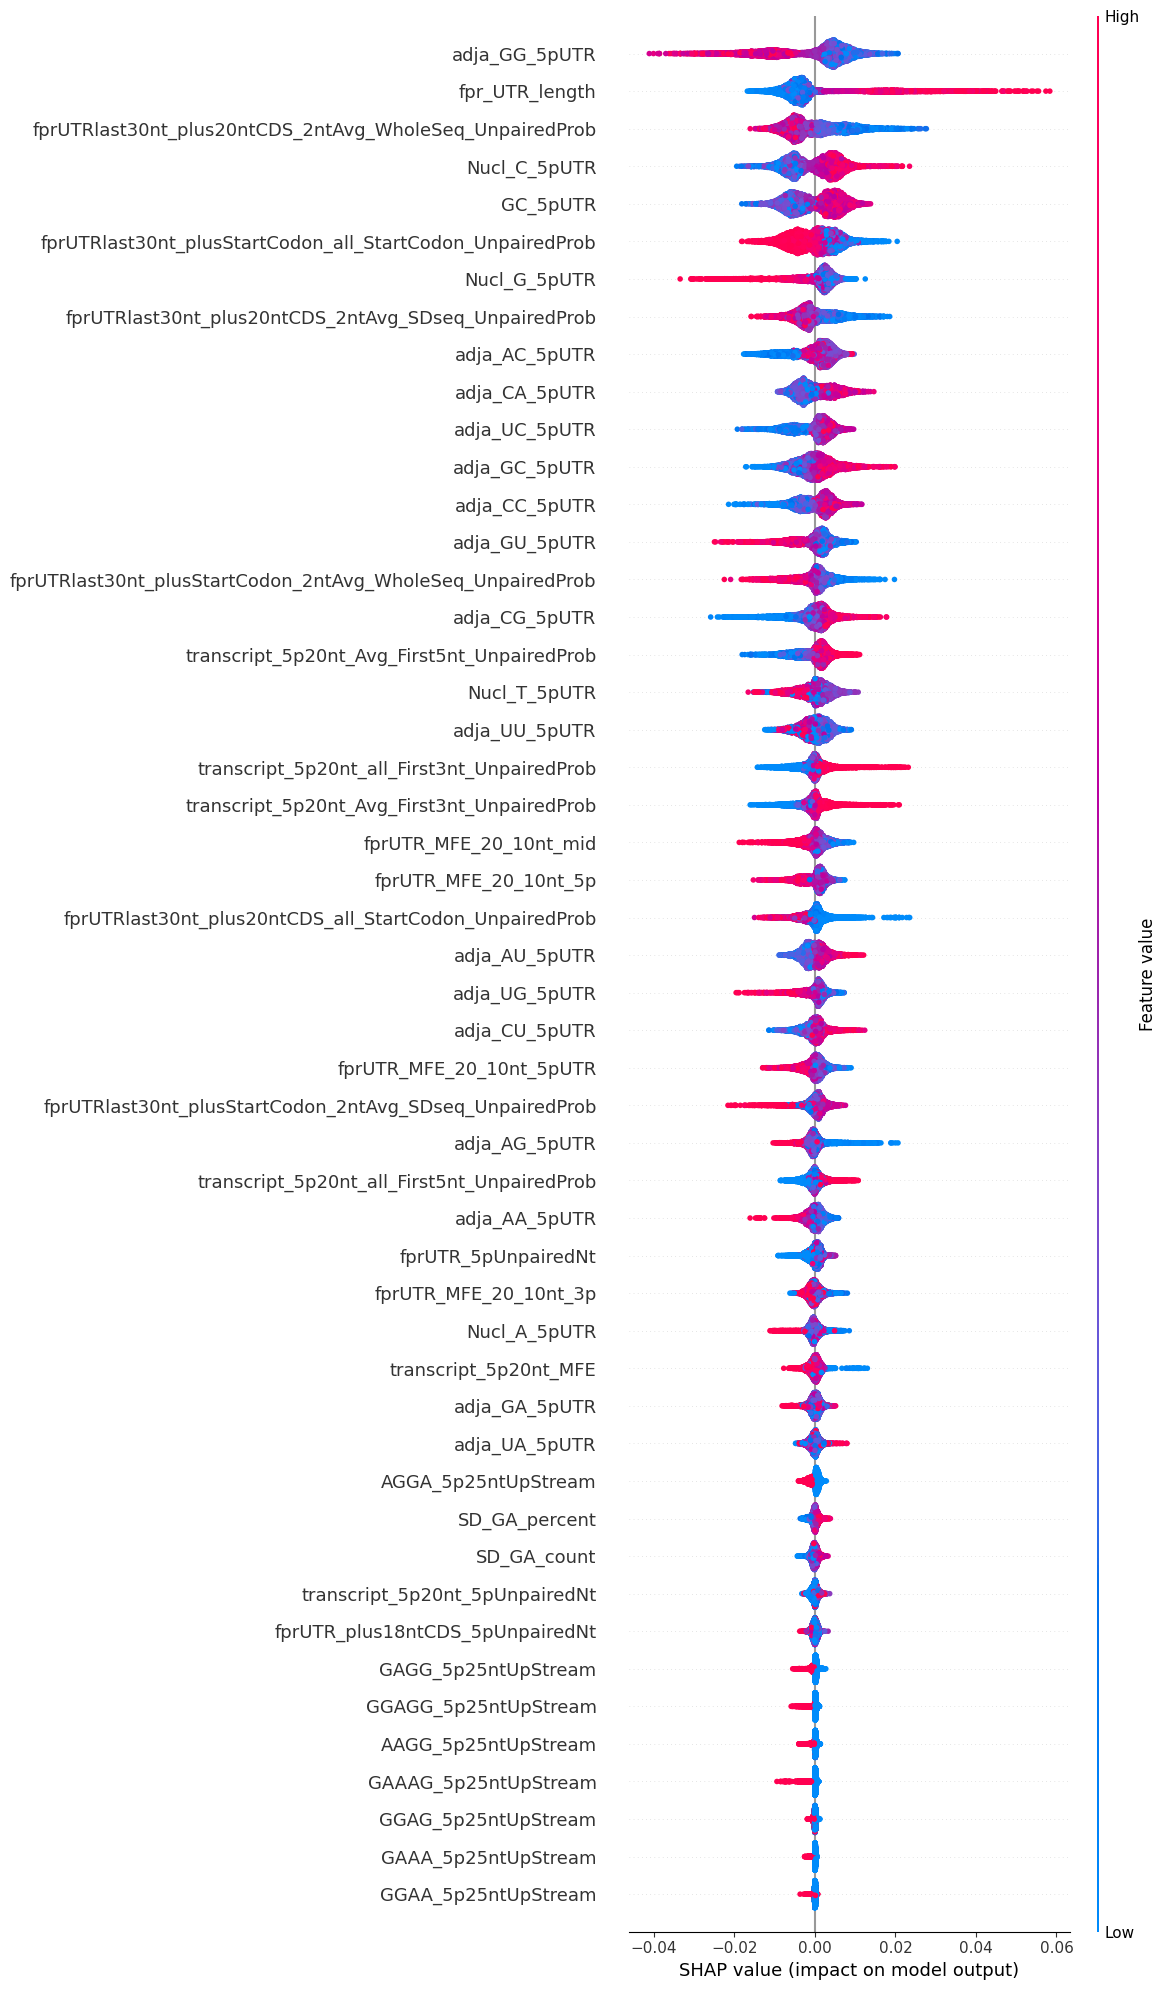

In [12]:
####### SHAP plots for each class
###### Large class

shap.summary_plot(shap_values[0], X_test, show = False, max_display = 50, plot_size = [12, 20])
plt.gcf().axes[-1].set_aspect(1000)
plt.gcf().axes[-1].set_box_aspect(1000)
plt.savefig("../SHAP_plotsPerClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_Large.pdf", dpi = 700, bbox_inches = "tight")


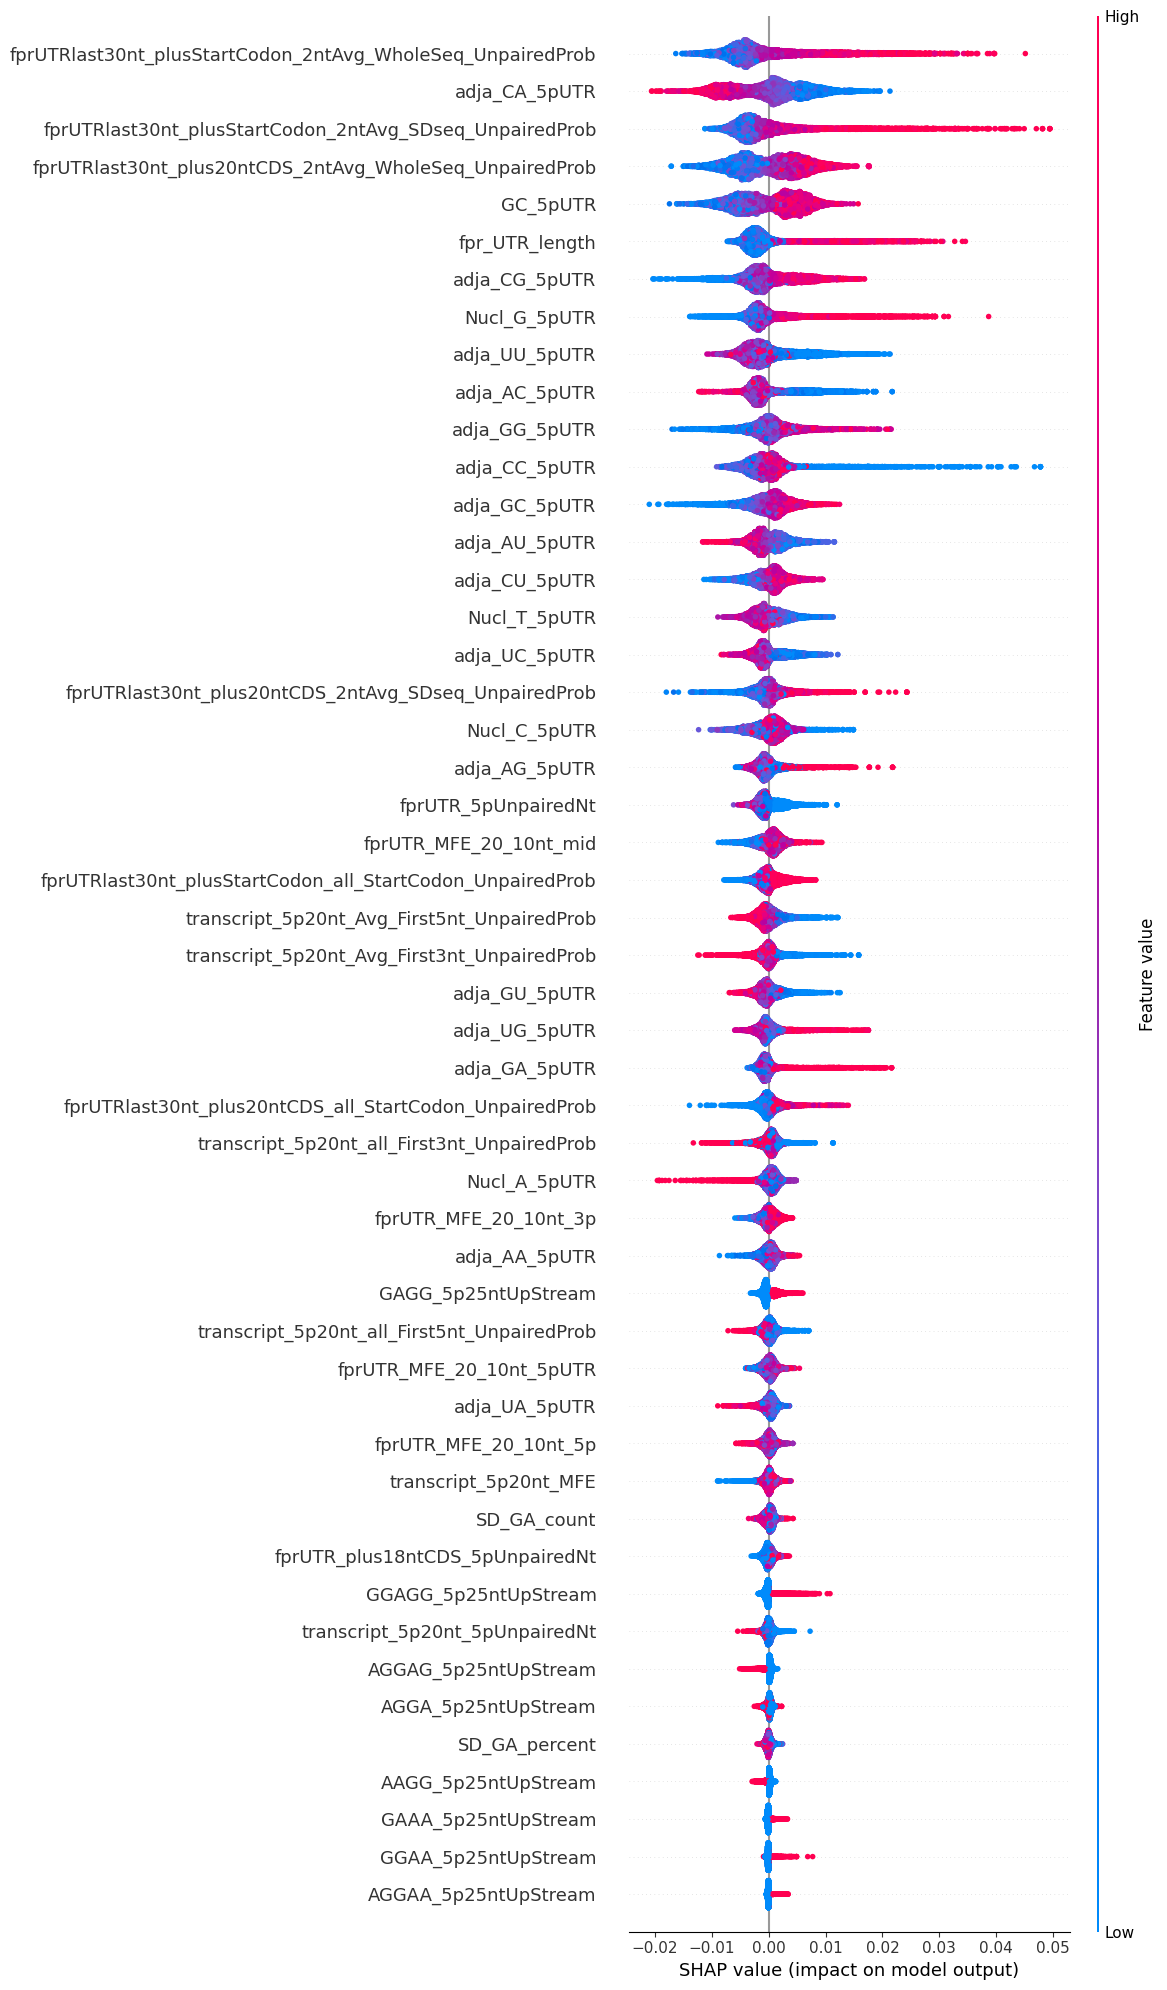

In [13]:
###### Med-Large class

shap.summary_plot(shap_values[1], X_test, show = False, max_display = 50, plot_size = [12, 20])
plt.gcf().axes[-1].set_aspect(1000)
plt.gcf().axes[-1].set_box_aspect(1000)
plt.savefig("../SHAP_plotsPerClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_MedLarge.pdf", dpi = 700, bbox_inches = "tight")


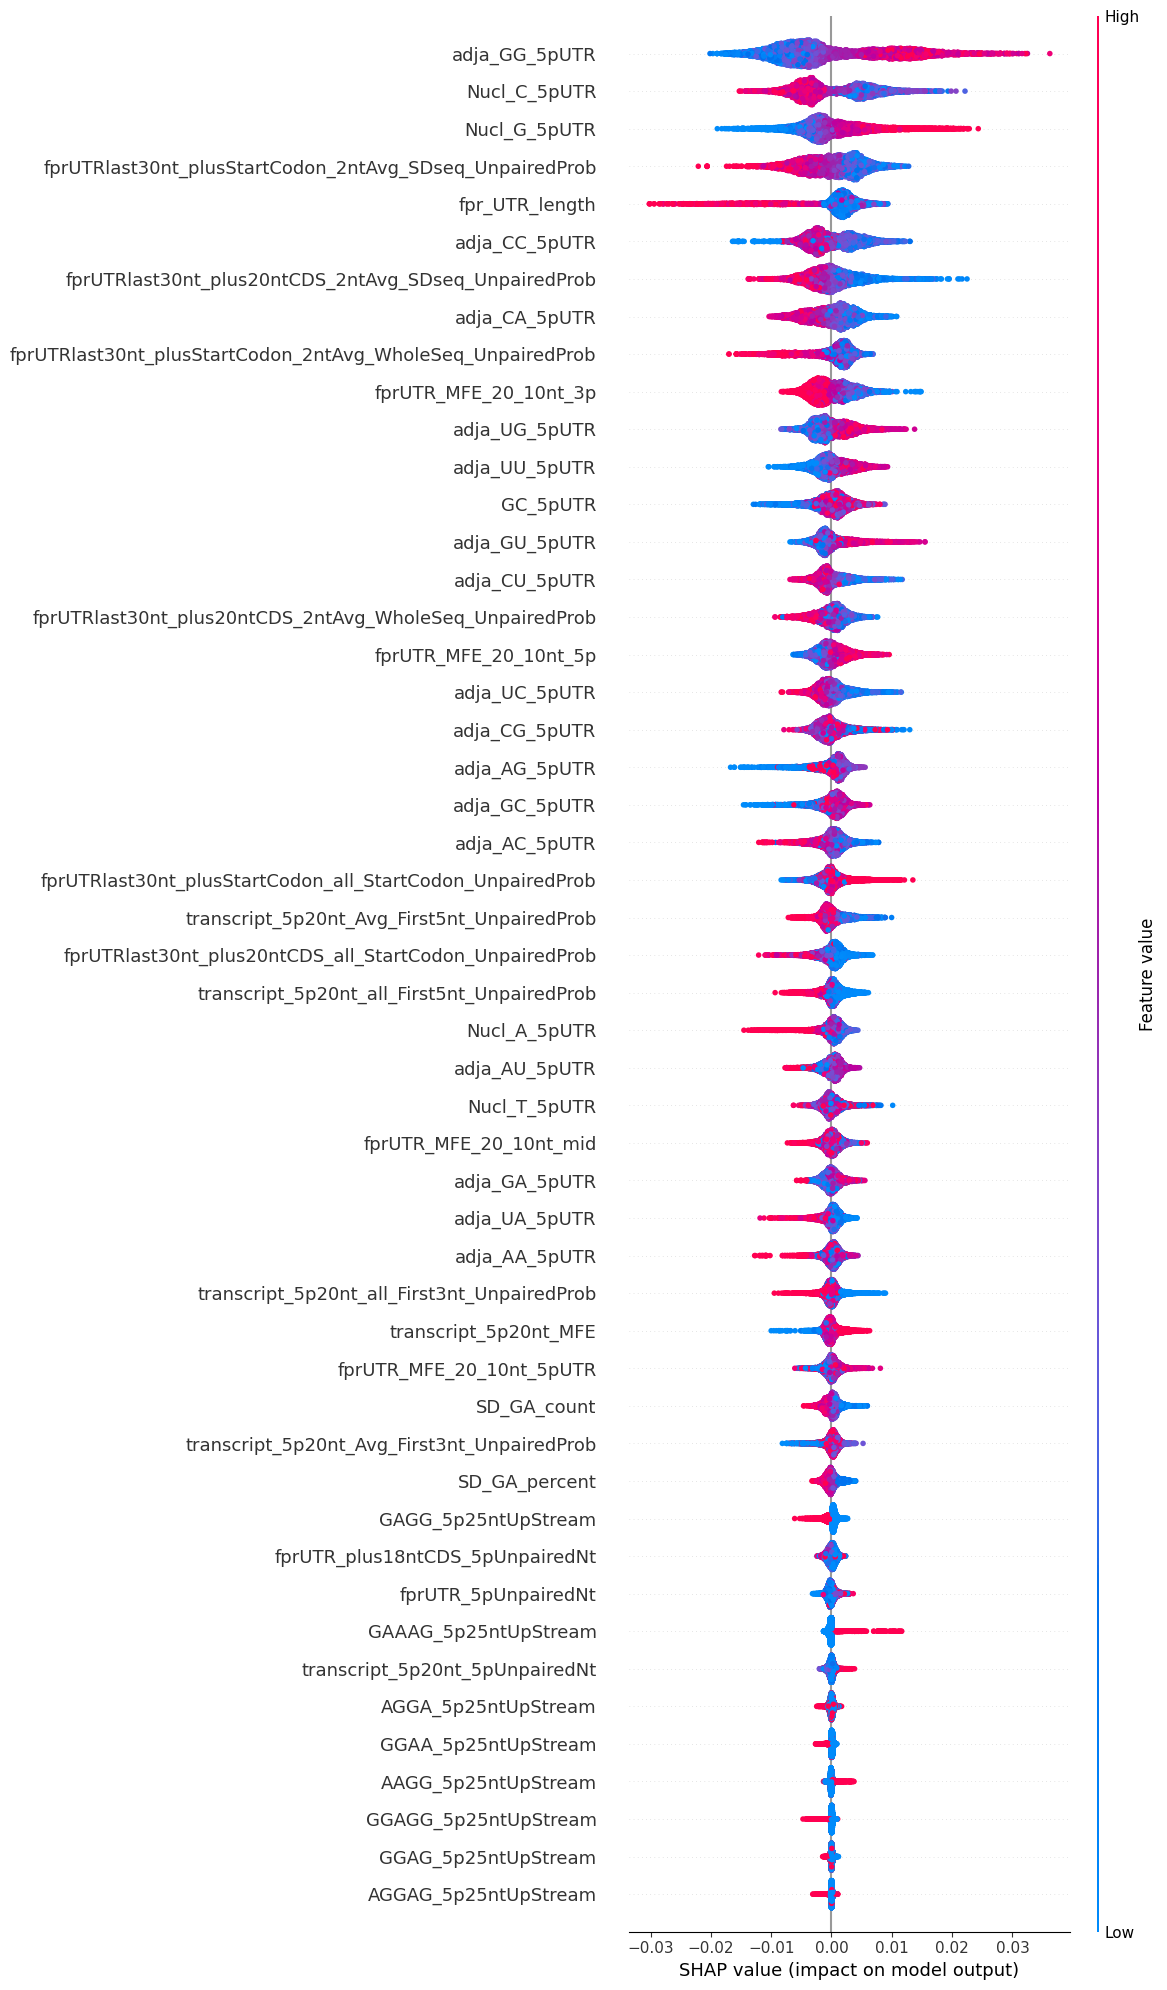

In [14]:
###### Med-Small class

shap.summary_plot(shap_values[2], X_test, show = False, max_display = 50, plot_size = [12, 20])
plt.gcf().axes[-1].set_aspect(1000)
plt.gcf().axes[-1].set_box_aspect(1000)
plt.savefig("../SHAP_plotsPerClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_MedSmall.pdf", dpi = 700, bbox_inches = "tight")


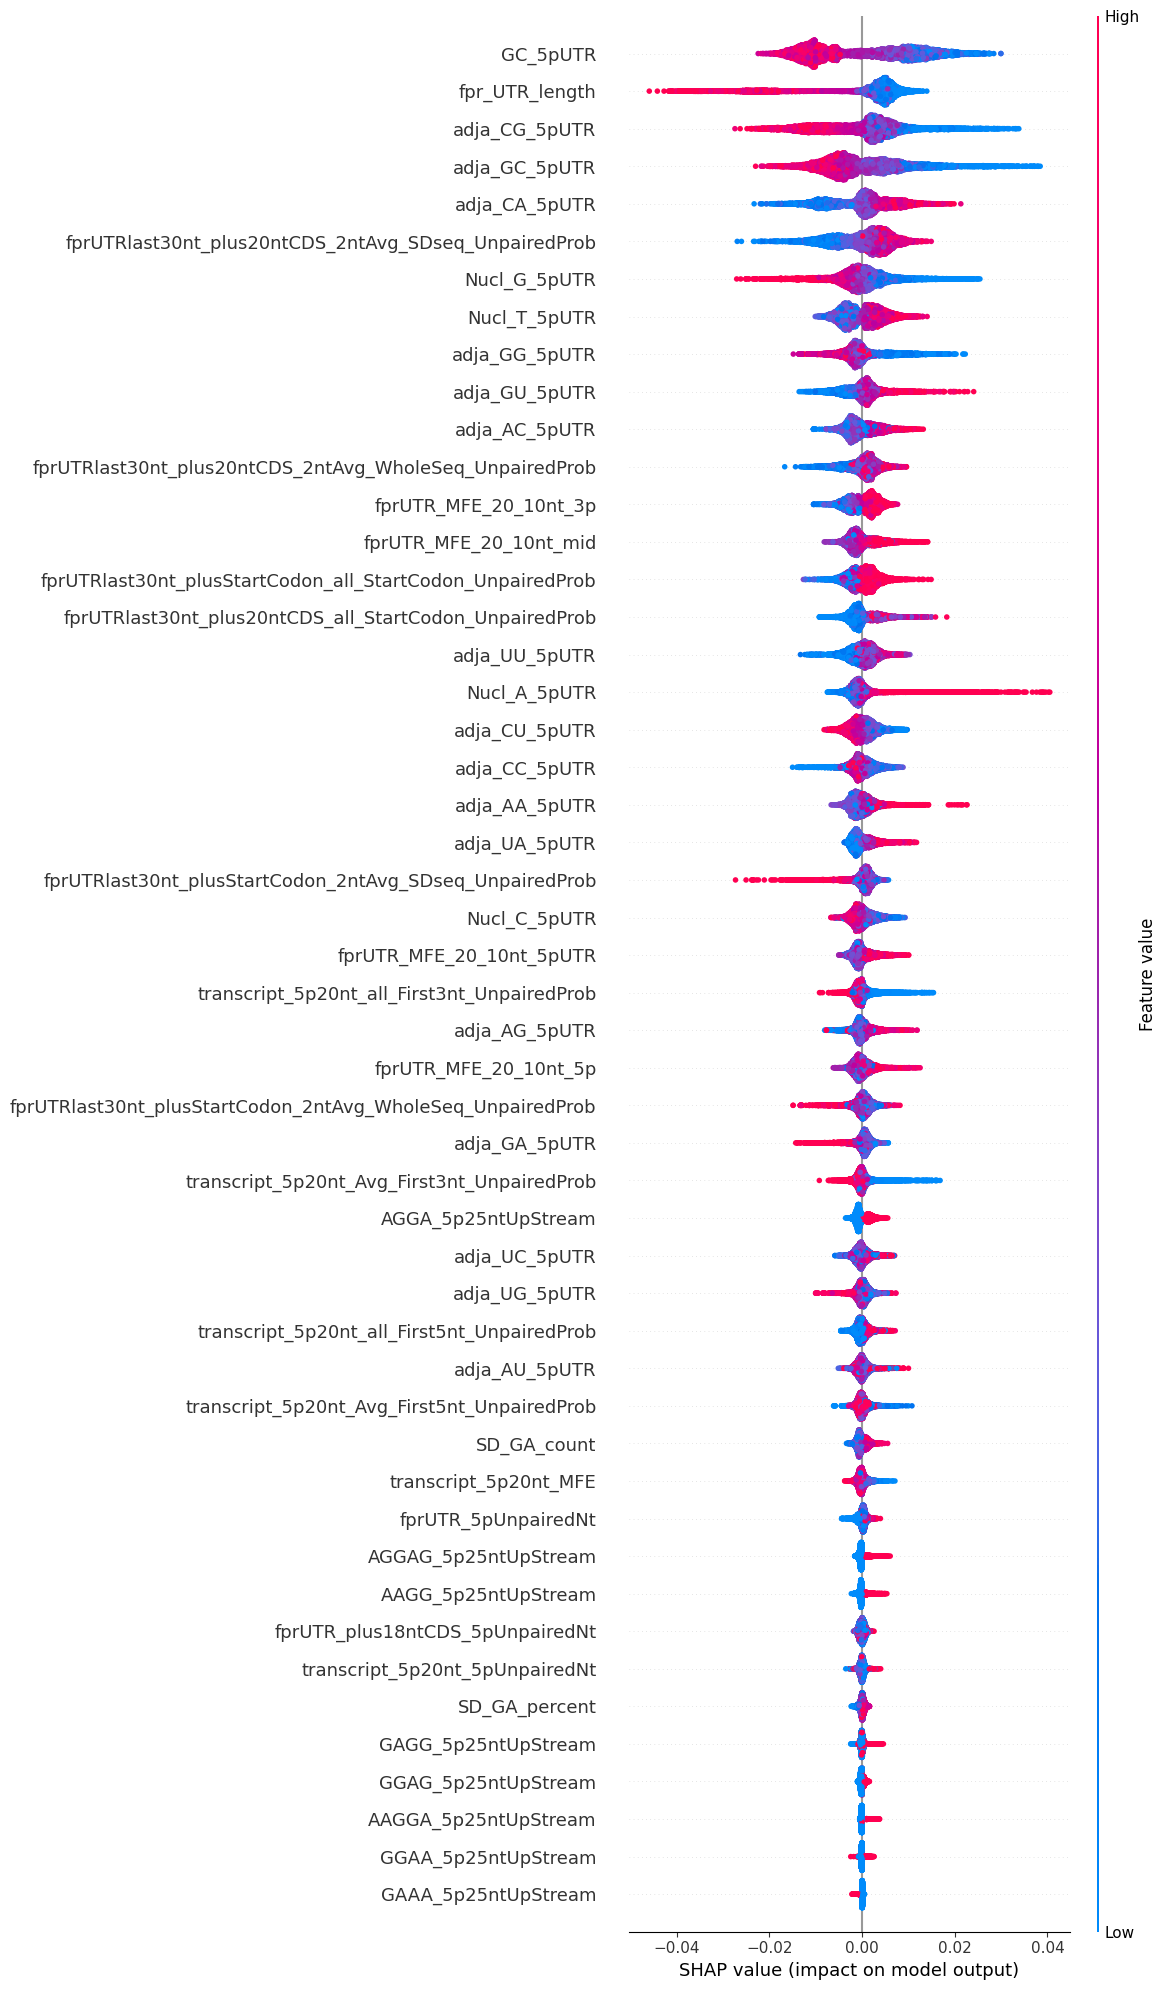

In [15]:
###### Small class

shap.summary_plot(shap_values[3], X_test, show = False, max_display = 50, plot_size = [12, 20])
plt.gcf().axes[-1].set_aspect(1000)
plt.gcf().axes[-1].set_box_aspect(1000)
plt.savefig("../SHAP_plotsPerClass/HalfLifeFcCls_hypoxiaToLogPhase_nonSelected_leadered_byType_5pUTR_complete_Small.pdf", dpi = 700, bbox_inches = "tight")
